prepare model 4D tensors

Dimension 1 (N): Represents the number of samples, which could correspond to days or time intervals for which data is available, depending on the specific dataset used.
Dimension 2 (w): Represents the lagging time-steps, arranged on the x-axis, with each time-step denoted as t - w + 1 to t, where "t" represents the current time-step. This dimension represents the temporal sequence of lagging time-steps.
Dimension 3 (u): Represents the number of links or roads in the network for which travel time measurements are available. This dimension represents the spatial dimension of the input data, with each link or road having its own value along this dimension.
Dimension 4 (1): Represents a single channel or feature, which in this case could represent the travel time measurements for each link at each time-step. This is a single-channel representation of the input data.

So, the 4D tensor X for input data would have the dimensionality N × w × u × 1, where N represents the number of samples, w represents the lagging time-steps, u represents the number of links, and 1 represents the single channel or feature for travel time measurements.

so in our case:
(n) - will be days
(w) - all routs in one day - 36
(u) - for start it will be num of links in line 16 - 46

In [2]:
import os
import pickle
import datetime as dt
import itertools

import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

numpy ver.: 1.23.5
pandas ver.: 2.0.1
tensorflow ver.: 2.12.0
keras ver.: 2.12.0


In [3]:
W = 36
U = 45

In [4]:
with open('../data/VMs.pickle', 'rb') as file:
    VMs_df = pickle.load(file)

VMs_df.head()

,Unnamed: 0,TripId,OPERATOR_ID,CLUSTER_ID,LINE_SHORT_NAME,OriginAimedDepartureTime,ID,stopOrder,actualArrivalTime,actualDepartureTime,Linkref,linkTime,time_first_stop(s),Link_travel_time(s)
0,0,1382474,3,91,106,2023-02-03 01:00:00.000,10106_1,2,2023-02-03T01:04:21,2023-02-03T01:05:10,4156:800,261,39,222
1,1,1382474,3,91,106,2023-02-03 01:00:00.000,10106_1,3,2023-02-03T01:05:59,2023-02-03T01:06:14,800:3375,98,49,49
2,2,1382474,3,91,106,2023-02-03 01:00:00.000,10106_1,4,2023-02-03T01:08:45,2023-02-03T01:08:59,3375:2024,166,15,151
3,3,1382474,3,91,106,2023-02-03 01:00:00.000,10106_1,5,2023-02-03T01:09:25,2023-02-03T01:09:42,2024:9862,40,14,26
4,4,1382474,3,91,106,2023-02-03 01:00:00.000,10106_1,6,2023-02-03T01:10:20,2023-02-03T01:10:36,9862:6134,55,17,38


In [5]:
# Filter rows with ID == "13016_1"
line16_df = VMs_df[VMs_df['ID'] == '13016_1'].copy()

line16_df['Day'] = pd.to_datetime(line16_df['OriginAimedDepartureTime']).dt.date
line16_df.sort_values(by=['Day'])
line16_days_dfs = [group_df.sort_values(['OriginAimedDepartureTime', 'stopOrder']) for _, group_df in line16_df.groupby('Day')]

In [6]:
# Amount of links
linkrefs = ['1089:9944', '9944:90', '90:2830', '2830:363', '363:365',
       '365:366', '366:367', '367:1428', '1428:2005', '2005:1825',
       '1825:105', '105:2781', '2781:2780', '2780:1336', '1336:112',
       '112:3859', '3859:115', '115:117', '117:119', '119:121', '121:123',
       '123:125', '125:127', '127:129', '129:9935', '9935:131',
       '131:1223', '1223:388', '388:172', '172:175', '175:177', '177:179',
       '179:278', '278:279', '279:5834', '5834:9897', '9897:547',
       '547:197', '197:551', '551:242', '242:554', '554:555', '555:5975',
       '5975:545', '545:2071']
assert(U == len(linkrefs))

# Amount of routs
routs_num = [
       '06:50:00.000', '07:10:00.000',
       '07:30:00.000', '07:50:00.000',
       '08:10:00.000', '08:40:00.000',
       '09:00:00.000', '09:30:00.000',
       '10:00:00.000', '10:30:00.000',
       '11:00:00.000', '11:30:00.000',
       '12:00:00.000', '12:30:00.000',
       '13:00:00.000', '13:30:00.000', 
       '14:00:00.000', '14:30:00.000', 
       '15:00:00.000', '15:30:00.000', 
       '16:00:00.000', '16:30:00.000', 
       '17:00:00.000', '17:30:00.000', 
       '18:00:00.000', '18:30:00.000', 
       '19:00:00.000', '19:30:00.000', 
       '20:00:00.000', '20:30:00.000', 
       '21:00:00.000', '21:35:00.000', 
       '22:10:00.000', '22:40:00.000', 
       '23:10:00.000', '23:40:00.000']
assert(W == len(routs_num))

tensor_shape_X = (len(routs_num), len(linkrefs), 1)
tensor_shape_Y = (len(linkrefs), 1)

In [7]:
VALID_MISS = 5
line16_default_tensor = np.zeros(tensor_shape_X)
line16_default_small_tensor = np.zeros(tensor_shape_Y)

for n, day_df in enumerate(line16_days_dfs):
    for (_, group_df) in day_df.groupby('OriginAimedDepartureTime'):
        for (_, row) in group_df.iterrows():
            time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
            if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                w_index = routs_num.index(time)
                u_index = linkrefs.index(row['Linkref'])
                
                line16_default_tensor[w_index, (u_index), 0] = (line16_default_tensor[w_index,(u_index), 0] + row['linkTime']) / 2
                # FIXME <something> / 2 it a moving average
                line16_default_small_tensor[(u_index), 0] = (line16_default_small_tensor[(u_index), 0] + row['linkTime']) / 2

In [8]:
tensors_X = []
tensors_Y = []

tensors_X1 = []
tensors_Y1 = []

for n, day_df in enumerate(line16_days_dfs):
    tensor_X = np.zeros(tensor_shape_X)
    for (_, group_df) in day_df.groupby('OriginAimedDepartureTime'):
            valid_u = ([0] * len(linkrefs))
            u_index = 0
            for (_, row) in group_df.iterrows():
                time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
                if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                    valid_u[u_index] = row['linkTime']
                    u_index+=1

            w_index = 0
            u_index = 0
            for (_, row) in group_df.iterrows():
                time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
                if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                    w_index = routs_num.index(time)
                    u_index = linkrefs.index(row['Linkref'])
                    
                    tensor_X[w_index, u_index, 0] = row['linkTime']
                    
                
                for u in range(u_index):
                    if tensor_X[w_index, u, 0] == 0:
                        tensor_X[w_index, u, 0] = line16_default_tensor[w_index, u, 0]

                tensors_X.append(tensor_X.copy())
                tensors_X1.append(tensor_X.copy()[w_index])

                tensor_Y = np.zeros(tensor_shape_Y)
                tensor_Y[u_index:, 0] = valid_u[u_index:]
                tensors_Y.append(tensor_Y)
                try:
                    tensors_Y1.append(valid_u[u_index+1])
                except:
                    a =tensors_X1.pop()

tensors_X1 = [list(itertools.chain.from_iterable(tensor.tolist())) for tensor in tensors_X1]

In [9]:
from sklearn.model_selection import train_test_split

tensors_X10stations = []
tensors_Y10stations = []

FULL_STATIONS = 9

for i, tensor in enumerate(tensors_X1):
    if tensor[FULL_STATIONS] != 0.0 and tensor[FULL_STATIONS+1] == 0.0:
        tensors_X10stations.append(tensors_X1[i][:FULL_STATIONS+1])
        tensors_Y10stations.append(tensors_Y1[i])

X10_train, X10_test, Y10_train, Y10_test = train_test_split(tensors_X10stations, tensors_Y10stations, test_size=0.05, random_state=42, shuffle=False)
# Split the training set into a training and validation set
x_train10, x_val10, y_train10, y_val10 = train_test_split(X10_train, Y10_train, test_size=0.1, random_state=42, shuffle=False)

Mean: 87.6126984126984
Median: 76.0
Mode: 70
Standard Deviation: 59.027566226153915
Variance: 3484.2535745829864
Range: 1043


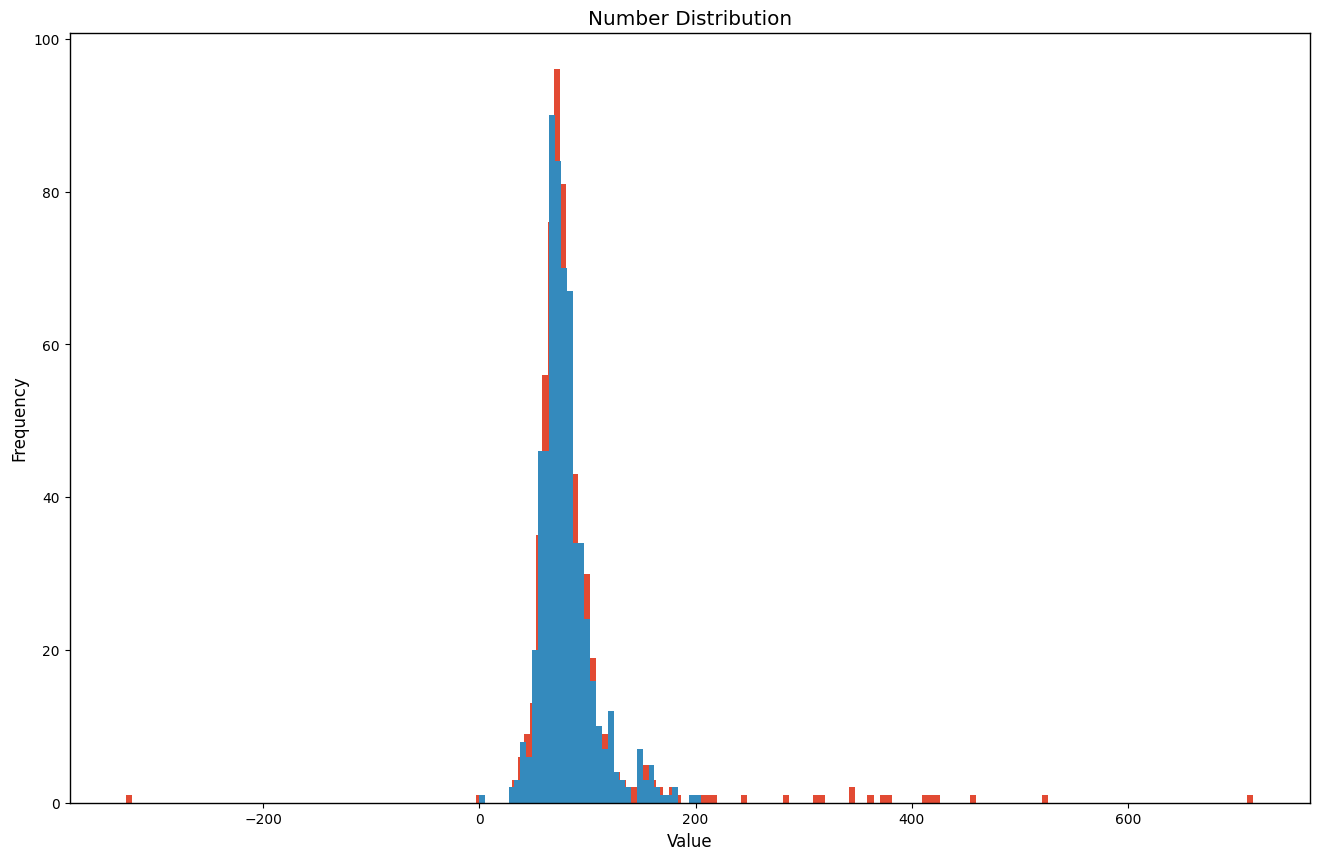

Number of values within 5 units from the mean: 79 : 12.53968253968254%
Number of values within 10 units from the mean: 174 : 27.61904761904762%
Number of values within 20 units from the mean: 384 : 60.952380952380956%


In [10]:
import statistics

# Calculate the mean
mean = statistics.mean(Y10_train)

# Calculate the median
median = statistics.median(Y10_train)

# Calculate the mode
mode = statistics.mode(Y10_train)

# Calculate the standard deviation
std_dev = statistics.stdev(Y10_train)

# Calculate the variance
variance = statistics.variance(Y10_train)

# Calculate the range
data_range = max(Y10_train) - min(Y10_train)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("Range:", data_range)

# Define the threshold as 2 standard deviations
threshold = 2 * std_dev
# Remove outliers from the list
Y10_train_without_outliers = [x for x in Y10_train if (mean - threshold) <= x <= (mean + threshold)]
mean_without_outliers = statistics.mean(Y10_train_without_outliers)

# Create a histogram plot
plt.hist(Y10_train, bins='auto')
plt.hist(Y10_train_without_outliers, bins='auto')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number Distribution')

# Display the plot
plt.show()

distances = [5, 10, 20]
# Count the number of values within each distance
count_within_distance = [len([x for x in Y10_train if abs(x - mean) <= distance]) for distance in distances]
# Calculate the percentage of values within each distance
percentage_within_distance = [count / len(Y10_train) * 100 for count in count_within_distance]
# Print the counts
for i, distance in enumerate(distances):
    print(f"Number of values within {distance} units from the mean: {count_within_distance[i]} : {percentage_within_distance[i]}%")

1. calc MEA error your self
2. try to play with the casting
3. understand how default accuracy is working

In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_accuracy(y_true, y_pred):
    # Compute the absolute difference between y_true and y_pred
    abs_diff = K.abs(mean_without_outliers - y_pred)

    # Convert boolean values to float32 for accuracy calculation
    accuracy = K.cast(abs_diff < 10.0, 'float32')

    return accuracy

def custom_distance_accuracy(y_true, y_pred):
    # Compute the absolute difference between y_true and y_pred
    abs_diff = K.abs(y_true - y_pred)

    # Convert boolean values to float32 for accuracy calculation
    accuracy = K.cast(abs_diff, 'float32')

    return accuracy

def build_model():
    model = Sequential()

    model.add(Dense(units=1, input_shape=(FULL_STATIONS+1,)))
    model.compile(optimizer=Adam(), loss = "MAE", metrics=[custom_accuracy, custom_distance_accuracy, tf.keras.metrics.MeanAbsoluteError()])
    
    '''
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    '''
    
    '''
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timestamps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    
    model.add(Dropout(0.21, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timestamps))
    model.add(Reshape((output_timestamps, num_links, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Flatten())
    model.add(Dense(units=256, name='dense_3', activation='relu'))
    model.add(Dense(units=164, name='dense_4', activation='relu'))
    model.add(Dense(units=164, name='dense_5', activation='relu'))

    # Add the final dense layer with output shape (45, 1)
    model.add(Dense(units=45, name='dense_6', activation='linear'))
    '''

    #optimizer = RMSprop()
    #model.compile(loss = "mse", optimizer = optimizer, metrics=['accuracy'])
    
    return model

In [12]:
print(len(tensors_X), len(tensors_Y))
print(tensors_X[0].shape, tensors_Y[0].shape)
tensors_X = np.array(tensors_X)
tensors_Y = np.array(tensors_Y)

34881 34881
(36, 45, 1) (45, 1)


In [13]:
from sklearn.model_selection import train_test_split

# Assuming tensors_X and tensors_Y are your data arrays
tensors_X = np.array(tensors_X)
tensors_Y = np.array(tensors_Y)

# Splitting the data into training and testing sets
test_size = 150  # Number of samples in the test set
random_state = 42  # Random seed for reproducibility

X_train, X_test, Y_train, Y_test = train_test_split(tensors_X, tensors_Y, test_size=test_size, random_state=random_state)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(tensors_X1, tensors_Y1, test_size=test_size, random_state=random_state)
# Split the training set into a training and validation set
x_train1, x_val1, y_train1, y_val1 = train_test_split(X_train1, Y_train1, test_size=0.1, random_state=42)

# Printing the shapes of the resulting sets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

print("Testing set shapes:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Training set shapes:
X_train: (34731, 36, 45, 1)
Y_train: (34731, 45, 1)
Testing set shapes:
X_test: (150, 36, 45, 1)
Y_test: (150, 45, 1)


In [19]:
h5_file = 'ConvLSTM_model.h5'

if os.path.exists(h5_file):
    model = tf.keras.models.load_model(h5_file)
    # Do something with the loaded model
    print("Model loaded successfully.")
else:
    #early_stopping = EarlyStopping(monitor='val_loss', patience = 3)
    
    model = build_model()

    #X10_train = np.array(X10_train, dtype=np.uint32)
    #Y10_train = np.array(Y10_train, dtype=np.uint32)

    history = model.fit(X10_train, Y10_train,
                    #batch_size = len(X10_train)-1, 
                    epochs = 100,
                    shuffle = True,
                    verbose = 2, validation_data=(x_val10, y_val10))
    
    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)
    # Save history as a CSV file
    #history_df.to_csv('model_history.csv', index=False)

    #model.save(h5_file)

Epoch 1/100
20/20 - 1s - loss: 210.5233 - custom_accuracy: 0.0063 - custom_distance_accuracy: 210.5233 - mean_absolute_error: 210.5233 - val_loss: 150.6965 - val_custom_accuracy: 0.0000e+00 - val_custom_distance_accuracy: 150.6965 - val_mean_absolute_error: 150.6965 - 622ms/epoch - 31ms/step
Epoch 2/100
20/20 - 0s - loss: 193.7343 - custom_accuracy: 0.0032 - custom_distance_accuracy: 193.7343 - mean_absolute_error: 193.7343 - val_loss: 134.6828 - val_custom_accuracy: 0.0000e+00 - val_custom_distance_accuracy: 134.6828 - val_mean_absolute_error: 134.6828 - 84ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 177.1873 - custom_accuracy: 0.0048 - custom_distance_accuracy: 177.1873 - mean_absolute_error: 177.1873 - val_loss: 118.5918 - val_custom_accuracy: 0.0000e+00 - val_custom_distance_accuracy: 118.5918 - val_mean_absolute_error: 118.5918 - 92ms/epoch - 5ms/step
Epoch 4/100
20/20 - 0s - loss: 161.2314 - custom_accuracy: 0.0048 - custom_distance_accuracy: 161.2314 - mean_absolute_error:

In [20]:
result = model.evaluate(X10_train, Y10_train)
loss_value = result[0]
custom_accuracy_value = result[1]
custom_distance_accuracy = result[2]
mean_absolute_error_value = result[3]

print("Loss value (MAE):", loss_value)
print("Custom accuracy value:", custom_accuracy_value)
print("Custom distance accuracy value:", custom_distance_accuracy)
print("Mean absolute error value:", mean_absolute_error_value)

20/20 [==============================] - 0s 958us/step - loss: 24.4355 - custom_accuracy: 0.4667 - custom_distance_accuracy: 24.4355 - mean_absolute_error: 24.4355
Loss value (MAE): 24.435523986816406
Custom accuracy value: 0.46666666865348816
Custom distance accuracy value: 24.435523986816406
Mean absolute error value: 24.435523986816406


In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_loss_and_accuracy(history, test_loss):

    # plot the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(test_loss, 'gx', label='Test Loss')
    
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
    plt.show()

    # Plot the training and validation mean absolute error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])

    plt.title('Model Mean absolute error Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')
    plt.show()

    plt.plot(history.history['custom_accuracy'])
    plt.plot(history.history['val_custom_accuracy'])

    plt.title('Model custom accuracy Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train Custom Acc', 'Validation Custom Acc'], loc='upper right')
    plt.show()

2/2 [==============================] - 0s 4ms/step - loss: 39.0033 - custom_accuracy: 0.4706 - mean_absolute_error: 39.0033
Train Mean absolute error: 24.600244522094727, Validation Mean absolute error: 17.427326202392578, (Test Mean absolute error: 39.00328063964844)
Train Custom accuracy value: 0.44797179102897644, Validation Custom accuracy value: 0.460317462682724, (Test Custom accuracy value: 0.47058823704719543)


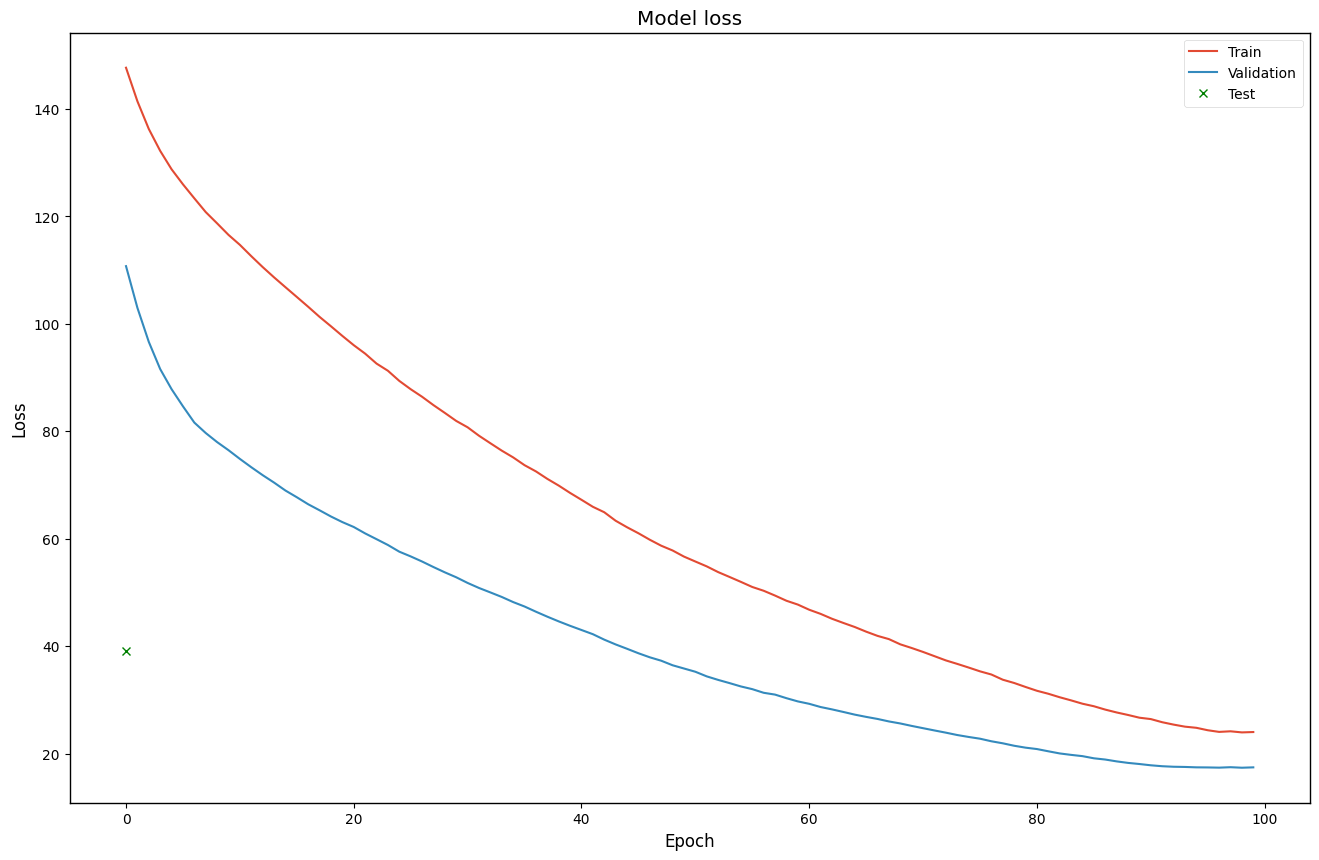

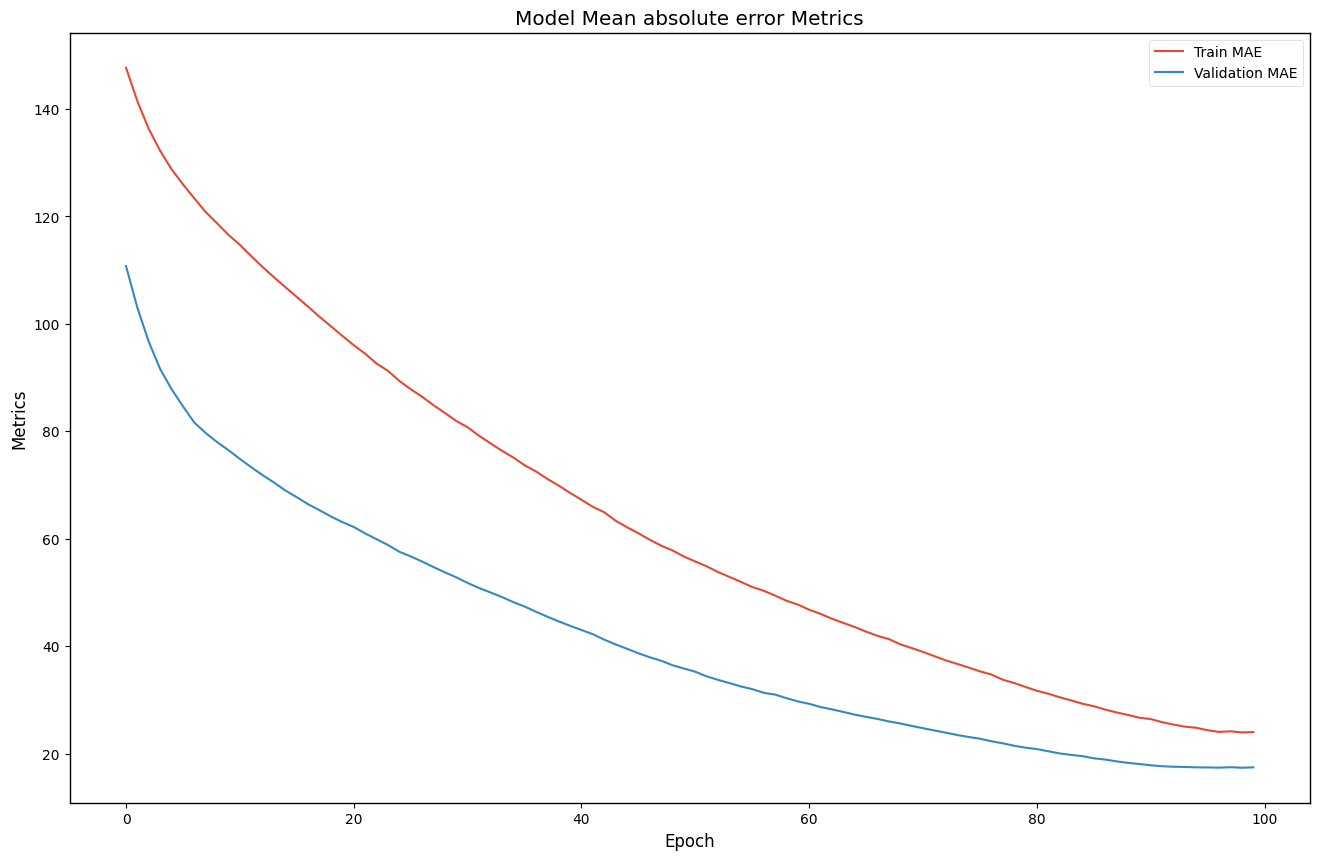

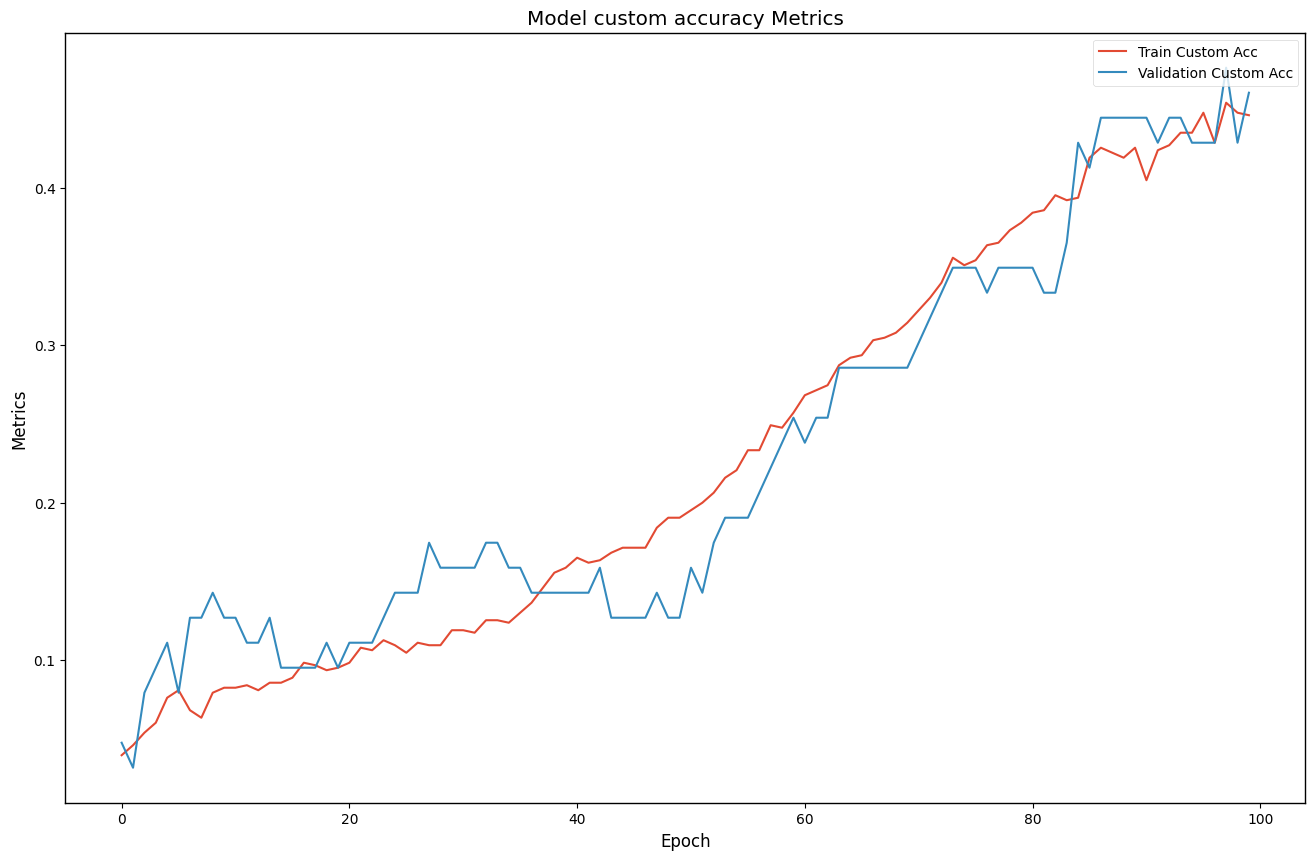

In [ ]:
# Evaluate the model on the training and validation sets
tloss_value, tcustom_accuracy_value, tmean_absolute_error_value = model.evaluate(x_train10, y_train10)
vloss_value, vcustom_accuracy_value, vmean_absolute_error_value = model.evaluate(x_val10, y_val10)
loss_value, custom_accuracy_value, mean_absolute_error_value = model.evaluate(X10_test, Y10_test)
print(f"Train Mean absolute error: {tmean_absolute_error_value}, Validation Mean absolute error: {vmean_absolute_error_value}, (Test Mean absolute error: {mean_absolute_error_value})")
print(f"Train Custom accuracy value: {tcustom_accuracy_value}, Validation Custom accuracy value: {vcustom_accuracy_value}, (Test Custom accuracy value: {custom_accuracy_value})")
    
plot_loss_and_accuracy(history, loss_value)